# Code Similarity: A Machine Learning Project

## Project Inicialization

In [27]:
import json, time, os
# from parser.parser import *
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

PROJECTS_FOLDER = f'{os.getcwd()}/Projects/'

DATA_FOLDER = f'{os.getcwd()}/data/'

os.makedirs(DATA_FOLDER, exist_ok=True)
pd.set_option('display.max_columns', None)


## Extrayendo Los AST

In [6]:

# PROJECTS_FOLDER = f'{os.getcwd()}/Projects/'

# DATA_FOLDER = f'{os.getcwd()}/data/'

# os.makedirs(DATA_FOLDER, exist_ok=True)

# project_features = []

# for f in os.scandir(PROJECTS_FOLDER):
#     if f.is_dir():
#         print(PROJECTS_FOLDER + f.name)
        
#         features = process_project(PROJECTS_FOLDER + f.name)
#         features['project_name'] = f.name
#         project_features.append(features)

# # Generar un nombre de archivo JSON único usando la marca de tiempo
# timestamp = time.strftime("%Y%m%d-%H%M%S")
# output_json_path = os.path.join(DATA_FOLDER, f"features_{timestamp}.json")

# # Guardar los features en un archivo JSON
# with open(output_json_path, 'w', encoding='utf-8') as json_file:
#     json.dump(project_features, json_file, ensure_ascii=False, indent=4)
  

## MOSS Baseline

## Data Loading

In [7]:
raw_data = pd.read_json('data/merged_features.json')
raw_data

,total_nodes,max_depth,number_of_variables,number_of_constants,out_variables,ref_params,number_of_methods,number_of_classes,number_of_interfaces,number_of_abstract_classes,number_of_sealed_classes,import_statements,number_of_try_blocks,number_of_lists,number_of_dictionaries,number_of_enums,number_of_delegates,function_calls,control_structures_if,control_structures_switch,control_structures_for,control_structures_while,control_structures_dowhile,access_modifiers_public,access_modifiers_private,access_modifiers_protected,access_modifiers_internal,access_modifiers_static,access_modifiers_protected_internal,access_modifiers_private_protected,modifier_readonly,modifier_volatile,modifier_virtual,modifier_override,modifier_new,modifier_partial,modifier_extern,modifier_unsafe,modifier_async,linq_querie_select,linq_queries_where,linq_queries_orderBy,linq_queries_groupBy,linq_queries_join,linq_queries_sum,linq_queries_count,library_call_console,library_call_math,number_of_lambdas,number_of_getters,number_of_setters,number_of_tuples,number_of_namespaces,node_count,project_name,label,project_type,variable_names_vector,delegate_names_vector,method_return_types_vector,method_names_vector,class_names_vector,interface_names_vector,enums_names_vector,method_parameters_vector
0,134895,3130,154,0,0,0,152,33,33,0,0,31,13,9,5,0,0,413,234,3,22,3,0,285,46,20,0,54,0,0,0,0,18,11,45,2,0,0,0,10,0,0,0,0,28,0,0,1,3,126,74,0,50,"{'Compilation_unitContext': 56, 'Namespace_mem...",JoseMiguel01012570345_Domino,original,domino,"[0.011499984189867, -0.017459969967603, 0.0764...",[],"[0.007172997109591001, -0.037290029227733, 0.1...","[0.0069025810807940005, -0.022520361468195003,...","[0.012977011501789001, -0.009228430688381, 0.0...","[0.0032115741632870003, -0.006917173042893, 0....",[],"[0.004410982597619, -0.017073033377528, 0.0711..."
1,50908,929,99,0,0,0,62,35,0,0,0,13,9,7,1,0,0,79,136,12,17,1,0,123,28,3,0,8,0,0,0,0,0,28,29,0,0,0,0,0,0,0,0,0,3,0,2,6,6,14,11,0,9,"{'Compilation_unitContext': 17, 'Using_directi...",Ramonconda_HulkProjec,original,hulk,"[-0.041838213801383, 0.008410186506807001, 0.0...",[],"[-0.044161222875118006, 0.009968493133783, 0.0...","[-0.01994789019227, -0.007205112837255, 0.0316...","[-0.014506132341921002, 0.005573478061705, 0.0...",[],[],"[-0.033015813678503, -0.001160686719231, 0.030..."
2,21992,830,26,5,0,0,33,12,0,0,0,11,4,0,0,0,0,26,25,0,5,0,0,60,54,4,7,19,0,0,25,0,0,11,22,0,0,0,0,4,4,0,0,0,13,0,1,9,17,7,4,0,12,"{'Compilation_unitContext': 15, 'Using_directi...",0mar-rivero_moogle-2021,original,moogle,"[0.015160501003265001, 0.012600116431713, 0.02...",[],"[-0.016169657930731, -0.00038655055686800005, ...","[-0.004541476257145001, -0.008107682690024001,...","[-0.0011802542721850002, 0.015644365921616003,...",[],[],"[-0.0037748056929550002, -0.007996526546776, 0..."
3,38989,549,106,0,0,0,36,7,0,0,0,6,1,2,4,1,0,105,85,5,2,13,0,51,11,0,0,2,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,30,0,5,6,0,6,3,0,7,"{'Compilation_unitContext': 7, 'Using_directiv...",kmy-cyber_INTERPRETE-C--to-HULK,original,hulk,"[-0.0033852290362110004, 0.008249028585851, 0....",[],"[-0.006297467742115001, 0.006423635408282001, ...","[-0.0036293801385900003, 0.001719191204756, 0....","[0.0011913196649400001, -0.0001390842953690000...",[],"[0.013611110858619001, -0.008294227533042, -0....","[0.0020935877691950003, -0.0028584217652670003..."
4,33426,859,109,0,0,0,28,9,0,0,0,1,0,3,1,0,0,44,69,0,41,0,0,73,1,0,0,54,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,2,0,0,6,0,32,31,1,9,"{'Compilation_unitContext': 10, 'Using_directi...",RodryJR_moogle,original,moogle,"[-0.001706766779534, 0.005043910350650001, 0.0...",[],"[-0.007784284185618001, -0.0018003111472350002...","[-0.0032052511814980003, -0.007833264768123, 0...","[0.010235144756734, -0.008743803948163001, 0.0...",[],[],"[-0.002058808458968, -0.007896041497588, 0.025..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [8]:
# Step 1: Identify columns with list values dynamically
list_columns = [col for col in raw_data.columns if isinstance(raw_data[col].iloc[0], list)]

# Step 2-4: Expand and concatenate for each list column
for list_column in list_columns:
    # Expand the lists into multiple columns
    expanded_cols = pd.DataFrame(raw_data[list_column].tolist(), index=raw_data.index)
    
    # Rename the expanded columns to match desired output
    expanded_cols.columns = [f'{list_column}-{i+1}' for i in range(expanded_cols.shape[1])]
    
    # Drop the original list column and concatenate the expanded columns
    raw_data = raw_data.drop(columns=[list_column]).join(expanded_cols)

# Replace NaN with appropriate values if needed (e.g., 0 or '')
raw_data = raw_data.fillna(np.nan)  # Or any other value like 0 or ''

# raw_data[['interface_names_vector-1', 'project_name', 'label']]

original_data = raw_data

raw_data = raw_data.drop(columns = ['project_type', 'label', 'delegate_names_vector-1', 'delegate_names_vector-2', 'node_count', 'project_name', 'modifier_volatile', 'access_modifiers_private_protected', 'access_modifiers_protected_internal', 'control_structures_dowhile', 'number_of_sealed_classes', 'modifier_volatile', 'modifier_unsafe', 'linq_queries_groupBy', 'linq_queries_count', 'modifier_extern'])
raw_data = raw_data.fillna(0)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Columns: 222 entries, total_nodes to method_parameters_vector-40
dtypes: float64(178), int64(44)
memory usage: 171.8 KB


## Difference Data

In [9]:
import itertools
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
# from listener import 

numeric_data = raw_data.select_dtypes(include=['float64', 'int64'])
project_type = original_data['project_type']

component_wise_differences = []

### Same project
sp_component_wise_diferences = []
### Diferent project
dp_component_wise_diferences = []

for (index1, row1), (index2, row2) in itertools.combinations(numeric_data.iterrows(), 2):
    difference = np.abs(row1.values - row2.values)
    component_wise_differences.append([index1, index2] + list(difference) + [int(project_type[index1] == project_type[index2])])
    if project_type[index1] == project_type[index2]:
        sp_component_wise_diferences.append([index1,index2]+list(difference) + [1])
    else:
        dp_component_wise_diferences.append([index1,index2]+list(difference) + [0])
        


columns = ['Index1', 'Index2'] + list(numeric_data.columns) + ['same_project']
# columns = list(numeric_data.columns)
component_wise_df = pd.DataFrame(component_wise_differences, columns=columns)
component_wise_df.head()
component_wise_df

,Index1,Index2,total_nodes,max_depth,number_of_variables,number_of_constants,out_variables,ref_params,number_of_methods,number_of_classes,number_of_interfaces,number_of_abstract_classes,import_statements,number_of_try_blocks,number_of_lists,number_of_dictionaries,number_of_enums,number_of_delegates,function_calls,control_structures_if,control_structures_switch,control_structures_for,control_structures_while,access_modifiers_public,access_modifiers_private,access_modifiers_protected,access_modifiers_internal,access_modifiers_static,modifier_readonly,modifier_virtual,modifier_override,modifier_new,modifier_partial,modifier_async,linq_querie_select,linq_queries_where,linq_queries_orderBy,linq_queries_join,linq_queries_sum,library_call_console,library_call_math,number_of_lambdas,number_of_getters,number_of_setters,number_of_tuples,number_of_namespaces,variable_names_vector-1,variable_names_vector-2,variable_names_vector-3,variable_names_vector-4,variable_names_vector-5,variable_names_vector-6,variable_names_vector-7,variable_names_vector-8,variable_names_vector-9,variable_names_vector-10,variable_names_vector-11,variable_names_vector-12,variable_names_vector-13,variable_names_vector-14,variable_names_vector-15,variable_names_vector-16,variable_names_vector-17,variable_names_vector-18,variable_names_vector-19,variable_names_vector-20,delegate_names_vector-3,delegate_names_vector-4,delegate_names_vector-5,delegate_names_vector-6,delegate_names_vector-7,delegate_names_vector-8,delegate_names_vector-9,delegate_names_vector-10,delegate_names_vector-11,delegate_names_vector-12,delegate_names_vector-13,delegate_names_vector-14,delegate_names_vector-15,delegate_names_vector-16,delegate_names_vector-17,delegate_names_vector-18,delegate_names_vector-19,delegate_names_vector-20,method_return_types_vector-1,method_return_types_vector-2,method_return_types_vector-3,method_return_types_vector-4,method_return_types_vector-5,method_return_types_vector-6,method_return_types_vector-7,method_return_types_vector-8,method_return_types_vector-9,method_return_types_vector-10,method_return_types_vector-11,method_return_types_vector-12,method_return_types_vector-13,method_return_types_vector-14,method_return_types_vector-15,method_return_types_vector-16,method_return_types_vector-17,method_return_types_vector-18,method_return_types_vector-19,method_return_types_vector-20,method_names_vector-1,method_names_vector-2,method_names_vector-3,method_names_vector-4,method_names_vector-5,method_names_vector-6,method_names_vector-7,method_names_vector-8,method_names_vector-9,method_names_vector-10,method_names_vector-11,method_names_vector-12,method_names_vector-13,method_names_vector-14,method_names_vector-15,method_names_vector-16,method_names_vector-17,method_names_vector-18,method_names_vector-19,method_names_vector-20,class_names_vector-1,class_names_vector-2,class_names_vector-3,class_names_vector-4,class_names_vector-5,class_names_vector-6,class_names_vector-7,class_names_vector-8,class_names_vector-9,class_names_vector-10,class_names_vector-11,class_names_vector-12,class_names_vector-13,class_names_vector-14,class_names_vector-15,class_names_vector-16,class_names_vector-17,class_names_vector-18,class_names_vector-19,class_names_vector-20,interface_names_vector-1,interface_names_vector-2,interface_names_vector-3,interface_names_vector-4,interface_names_vector-5,interface_names_vector-6,interface_names_vector-7,interface_names_vector-8,interface_names_vector-9,interface_names_vector-10,interface_names_vector-11,interface_names_vector-12,interface_names_vector-13,interface_names_vector-14,interface_names_vector-15,interface_names_vector-16,interface_names_vector-17,interface_names_vector-18,interface_names_vector-19,interface_names_vector-20,enums_names_vector-1,enums_names_vector-2,enums_names_vector-3,enums_names_vector-4,enums_names_vector-5,enums_names_vector-6,enums_names_vector-7,enums_names_vector-8,enums_names_vector-9,enums_names_vector-10,enums_names

In [10]:
### Asegurar que la proporcion entre test y test sea la misma (1, 0)
# component_wise_df

sp_component_wise_df = pd.DataFrame(sp_component_wise_diferences, columns=columns)
# sp_component_wise_df
sp_train_df, sp_test_df = train_test_split(sp_component_wise_df, test_size=0.2, random_state=42)

# 
dp_component_wise_df = pd.DataFrame(dp_component_wise_diferences, columns=columns)
# dp_component_wise_df
dp_train_df, dp_test_df = train_test_split(dp_component_wise_df, test_size=0.2, random_state=42)


train_df = pd.concat([dp_train_df,sp_train_df], ignore_index=True)
test_df = pd.concat([dp_test_df,sp_test_df], ignore_index=True)
### Dividir en train y test.


## Selecting Data

In [11]:
data = component_wise_df
# data = raw_data
data = train_df

In [12]:
# Define a function to check if a column should be converted to int
def is_float_int(column):
    return pd.api.types.is_float_dtype(column) and (column % 1 == 0).all()

# Detect and convert columns
int_columns = [col for col in data.columns if is_float_int(data[col])]
data[int_columns] = data[int_columns].astype(int)

# Verify the changes
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3880 entries, 0 to 3879
Columns: 225 entries, Index1 to same_project
dtypes: float64(178), int64(47)
memory usage: 6.7 MB


## Processing data

In [13]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Index1,3880.0,32.712887,23.189148,0.000000e+00,13.000000,29.000000,49.000000,97.000000
Index2,3880.0,65.543041,23.049331,2.000000e+00,49.000000,69.000000,85.000000,98.000000
total_nodes,3880.0,43742.392526,50428.737266,5.000000e+00,11415.750000,25478.000000,56703.000000,289665.000000
max_depth,3880.0,1257.813660,1311.688188,0.000000e+00,307.750000,753.500000,1840.500000,6826.000000
number_of_variables,3880.0,94.414433,129.358689,0.000000e+00,25.000000,55.000000,105.000000,873.000000
...,...,...,...,...,...,...,...,...
method_parameters_vector-37,3880.0,0.090025,0.107308,3.204867e-05,0.016913,0.041284,0.120147,0.537152
method_parameters_vector-38,3880.0,0.027178,0.039090,4.284084e-08,0.007672,0.016650,0.030093,0.386901
method_parameters_vector-39,3880.0,0.055760,0.070850,5.669892e-06,0.011015,0.025407,0.072651,0.332706
method_parameters_vector-40,3880.0,0.084696,0.123568,1.429068e-05,0.014370,0.032237,0.085508,0.587866


In [14]:

same_pt = test_df[test_df['same_project'] == 1]
same_pt

,Index1,Index2,total_nodes,max_depth,number_of_variables,number_of_constants,out_variables,ref_params,number_of_methods,number_of_classes,number_of_interfaces,number_of_abstract_classes,import_statements,number_of_try_blocks,number_of_lists,number_of_dictionaries,number_of_enums,number_of_delegates,function_calls,control_structures_if,control_structures_switch,control_structures_for,control_structures_while,access_modifiers_public,access_modifiers_private,access_modifiers_protected,access_modifiers_internal,access_modifiers_static,modifier_readonly,modifier_virtual,modifier_override,modifier_new,modifier_partial,modifier_async,linq_querie_select,linq_queries_where,linq_queries_orderBy,linq_queries_join,linq_queries_sum,library_call_console,library_call_math,number_of_lambdas,number_of_getters,number_of_setters,number_of_tuples,number_of_namespaces,variable_names_vector-1,variable_names_vector-2,variable_names_vector-3,variable_names_vector-4,variable_names_vector-5,variable_names_vector-6,variable_names_vector-7,variable_names_vector-8,variable_names_vector-9,variable_names_vector-10,variable_names_vector-11,variable_names_vector-12,variable_names_vector-13,variable_names_vector-14,variable_names_vector-15,variable_names_vector-16,variable_names_vector-17,variable_names_vector-18,variable_names_vector-19,variable_names_vector-20,delegate_names_vector-3,delegate_names_vector-4,delegate_names_vector-5,delegate_names_vector-6,delegate_names_vector-7,delegate_names_vector-8,delegate_names_vector-9,delegate_names_vector-10,delegate_names_vector-11,delegate_names_vector-12,delegate_names_vector-13,delegate_names_vector-14,delegate_names_vector-15,delegate_names_vector-16,delegate_names_vector-17,delegate_names_vector-18,delegate_names_vector-19,delegate_names_vector-20,method_return_types_vector-1,method_return_types_vector-2,method_return_types_vector-3,method_return_types_vector-4,method_return_types_vector-5,method_return_types_vector-6,method_return_types_vector-7,method_return_types_vector-8,method_return_types_vector-9,method_return_types_vector-10,method_return_types_vector-11,method_return_types_vector-12,method_return_types_vector-13,method_return_types_vector-14,method_return_types_vector-15,method_return_types_vector-16,method_return_types_vector-17,method_return_types_vector-18,method_return_types_vector-19,method_return_types_vector-20,method_names_vector-1,method_names_vector-2,method_names_vector-3,method_names_vector-4,method_names_vector-5,method_names_vector-6,method_names_vector-7,method_names_vector-8,method_names_vector-9,method_names_vector-10,method_names_vector-11,method_names_vector-12,method_names_vector-13,method_names_vector-14,method_names_vector-15,method_names_vector-16,method_names_vector-17,method_names_vector-18,method_names_vector-19,method_names_vector-20,class_names_vector-1,class_names_vector-2,class_names_vector-3,class_names_vector-4,class_names_vector-5,class_names_vector-6,class_names_vector-7,class_names_vector-8,class_names_vector-9,class_names_vector-10,class_names_vector-11,class_names_vector-12,class_names_vector-13,class_names_vector-14,class_names_vector-15,class_names_vector-16,class_names_vector-17,class_names_vector-18,class_names_vector-19,class_names_vector-20,interface_names_vector-1,interface_names_vector-2,interface_names_vector-3,interface_names_vector-4,interface_names_vector-5,interface_names_vector-6,interface_names_vector-7,interface_names_vector-8,interface_names_vector-9,interface_names_vector-10,interface_names_vector-11,interface_names_vector-12,interface_names_vector-13,interface_names_vector-14,interface_names_vector-15,interface_names_vector-16,interface_names_vector-17,interface_names_vector-18,interface_names_vector-19,interface_names_vector-20,enums_names_vector-1,enums_names_vector-2,enums_names_vector-3,enums_names_vector-4,enums_names_vector-5,enums_names_vector-6,enums_names_vector-7,enums_names_vector-8,enums_names_vector-9,enums_names_vector-10,enums_names

<Axes: >

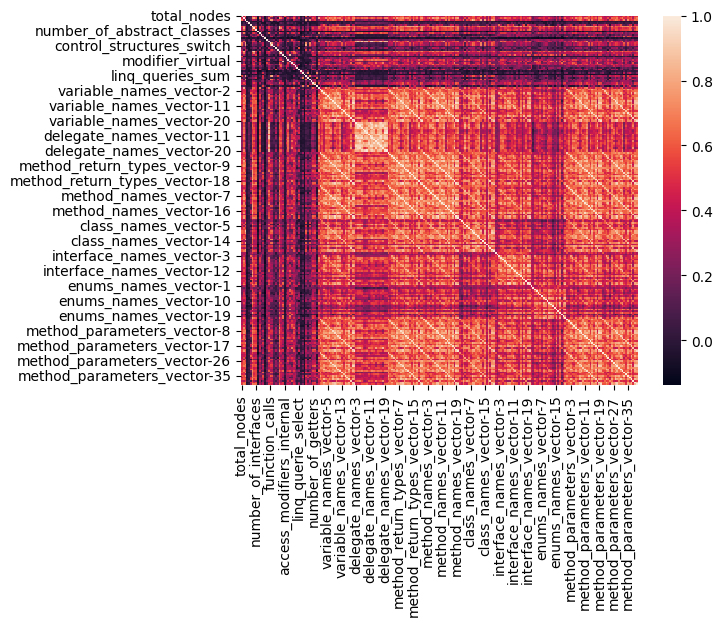

In [15]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# data = data.drop(columns=['Index1', 'Index2'])# TODO: Ubicar bien esto

# Data Normalization
scaler = StandardScaler()
important_data = data.drop(columns=['Index1', 'Index2', 'same_project'])
same_pt = test_df[test_df['same_project'] == 1]
test_df = test_df[test_df['same_project'] == 0]

important_data_test = test_df.drop(columns=['Index1', 'Index2', 'same_project'])
same_pt = same_pt.drop(columns=['Index1', 'Index2', 'same_project'])

scaled_test = pd.DataFrame(scaler.fit_transform(important_data_test), columns=important_data_test.columns)

scaled_data = pd.DataFrame(scaler.fit_transform(important_data), columns=important_data.columns)

same_pt = pd.DataFrame(scaler.fit_transform(same_pt), columns=important_data_test.columns)

# Perform correlation analysis
correlation_matrix = scaled_data.corr()

# Filtering weak correlations
threshold = 1
strong_correlations = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]

# Visualize the correlation matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(strong_correlations, annot=True, cmap='coolwarm', fmt='.2f')
sns.heatmap(correlation_matrix)#TODO: Some values are resulting in NAN, fix this
# plt.show()

In [16]:
strong_correlations['total_nodes']

total_nodes                    1.0
max_depth                      NaN
number_of_variables            NaN
number_of_constants            NaN
out_variables                  NaN
                              ... 
method_parameters_vector-36    NaN
method_parameters_vector-37    NaN
method_parameters_vector-38    NaN
method_parameters_vector-39    NaN
method_parameters_vector-40    NaN
Name: total_nodes, Length: 222, dtype: float64

In [17]:
for feature in data.columns:
    stat, p = stats.shapiro(data[feature].dropna())
    if p > 0.05:
        print(f'{feature} is likely normally distributed (fail to reject H0)')


## One Class SVM

In [18]:
from sklearn.svm import OneClassSVM

# Assuming X_train contains your distance vectors of unique data points
X_train = scaled_data
X_test = scaled_test
# new_data = np.array([...])

# Train One-Class SVM
ocsvm = OneClassSVM(kernel='rbf', gamma='auto')
ocsvm.fit(X_train)

# Combine training and new data for visualization
# combined_data = np.vstack([X_train, new_data])

# Predict on combined data

# pred = ocsvm.predict(combined_data)
pred = ocsvm.decision_function(X_train)
# X_train = X_train.join(aux)
labels = ['Inlier' if p >= 0.5 else 'Outlier' for p in pred]

### T-SNE Dimensionality Reduction Visualization 

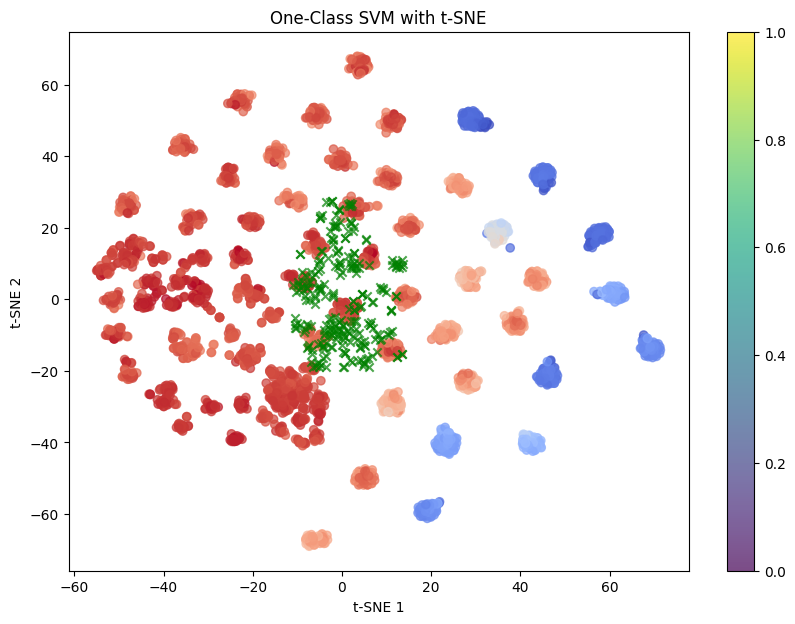

In [19]:
from sklearn.manifold import TSNE

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)

# tsne_results = tsne.fit_transform(combined_data)
tsne_results = tsne.fit_transform(X_train)
tsne_results_same_pt = tsne.fit_transform(same_pt)

# Plot the results
plt.figure(figsize=(10, 7))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=pred, cmap='coolwarm', alpha=0.7)
plt.scatter(tsne_results_same_pt[:, 0], tsne_results_same_pt[:, 1], marker='x', color='green', alpha=0.7, label='Test Data')
plt.title('One-Class SVM with t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar()
plt.show()

### PCA Dimensionality Redution Visualization

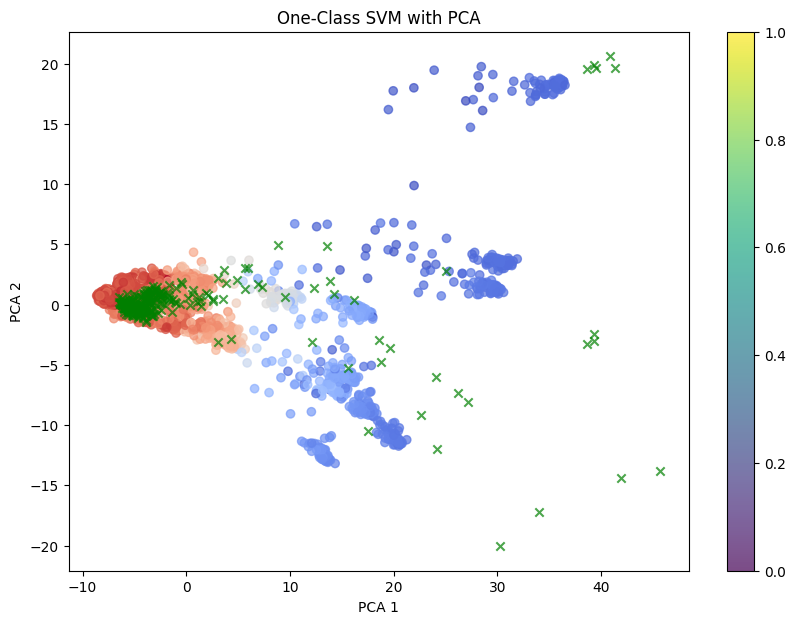

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
# pca_results = pca.fit_transform(combined_data)
pca_results = pca.fit_transform(X_train)
tsne_results_same_pt = pca.fit_transform(same_pt)

# Plot the results
plt.figure(figsize=(10, 7))
plt.scatter(pca_results[:, 0], pca_results[:, 1], c=pred, cmap='coolwarm', alpha=0.7)
plt.scatter(tsne_results_same_pt[:, 0], tsne_results_same_pt[:, 1], marker='x', color='green', alpha=0.7, label='Test Data')
plt.title('One-Class SVM with PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.show()

### Evaluating model

In [21]:
y_pred_train = ocsvm.decision_function(X_train)
y_pred_test = ocsvm.decision_function(X_test)
n_error_train = y_pred_train[y_pred_train <= -400].size
n_error_test = y_pred_test[y_pred_test <= -400].size
print(f'error train: {n_error_train}/{len(X_train)} ; errors test: {n_error_test}/{len(X_test)}')

error train: 674/3880 ; errors test: 128/712


## Isolation Forest

In [22]:
from sklearn.ensemble import IsolationForest

# Assuming X_train contains your distance vectors of unique data points
X_train = scaled_data
X_test = scaled_test
# new_data = np.array([...])

# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.1)
iso_forest.fit(X_train)

# Combine training and new data for visualization
# combined_data = np.vstack([X_train, new_data])

# Predict on combined data

# pred = ocsvm.predict(combined_data)
pred = iso_forest.decision_function(X_train)
labels = ['Inlier' if p >= 0.5 else 'Outlier' for p in pred]


### T-SNE Dimensionality Reduction Visualization 

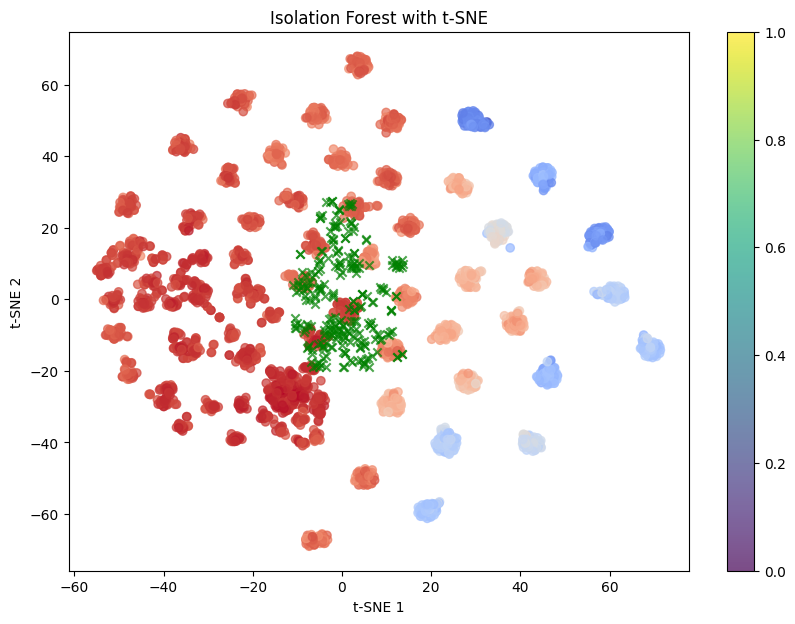

In [23]:
from sklearn.manifold import TSNE

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)

# tsne_results = tsne.fit_transform(combined_data)
tsne_results = tsne.fit_transform(X_train)
tsne_results_same_pt = tsne.fit_transform(same_pt)

# Plot the results
plt.figure(figsize=(10, 7))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=pred, cmap='coolwarm', alpha=0.7)
plt.scatter(tsne_results_same_pt[:, 0], tsne_results_same_pt[:, 1], marker='x', color='green', alpha=0.7, label='Test Data')
plt.title('Isolation Forest with t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar()
plt.show()

### PCA Dimensionality Redution Visualization

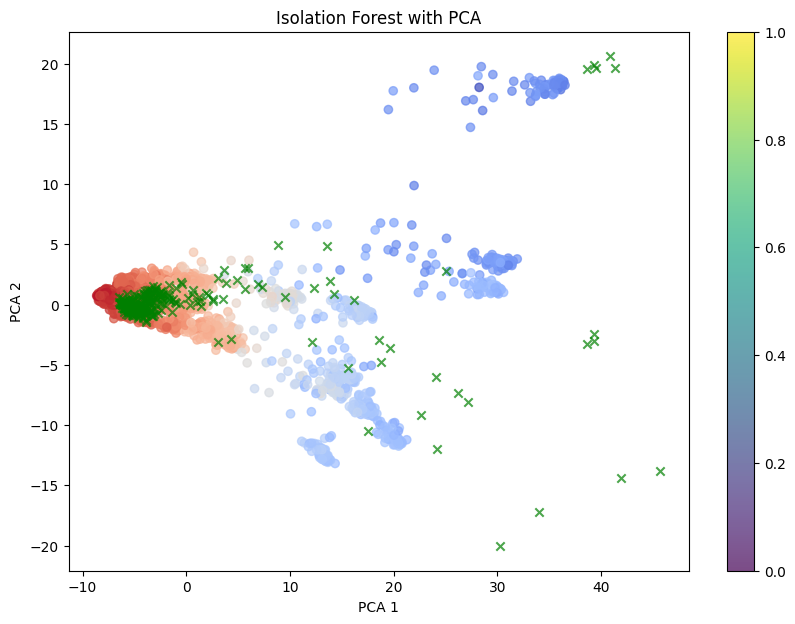

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
# pca_results = pca.fit_transform(combined_data)
pca_results = pca.fit_transform(X_train)
tsne_results_same_pt = pca.fit_transform(same_pt)

# Plot the results
plt.figure(figsize=(10, 7))
plt.scatter(pca_results[:, 0], pca_results[:, 1], c=pred, cmap='coolwarm', alpha=0.7)
plt.scatter(tsne_results_same_pt[:, 0], tsne_results_same_pt[:, 1], marker='x', color='green', alpha=0.7, label='Test Data')
plt.title('Isolation Forest with PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.show()

### Evaluating

In [25]:
y_pred_train = iso_forest.decision_function(X_train)
y_pred_test = iso_forest.decision_function(X_test)
n_error_train = y_pred_train[y_pred_train <= 0].size
n_error_test = y_pred_test[y_pred_test <= 0].size
print(f'error train: {n_error_train}/{len(X_train)} ; errors test: {n_error_test}/{len(X_test)}')

error train: 388/3880 ; errors test: 63/712


## Clustering

### K-Means

In [28]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Seleccionar columnas numéricas
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Normalizar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Definir el número de clusters
# num_clusters = 2

# Crear y ajustar el modelo K-Means
wcss = []
for i in range(1, 100):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=10, random_state=1, )
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Añadir las etiquetas de los clusters al DataFrame original
# data['Cluster'] = kmeans.labels_




Silhouette Score: 0.20431759755240692
Davies-Bouldin Score: 1.6893894948955073
Calinski-Harabasz Score: 317.84458238355336


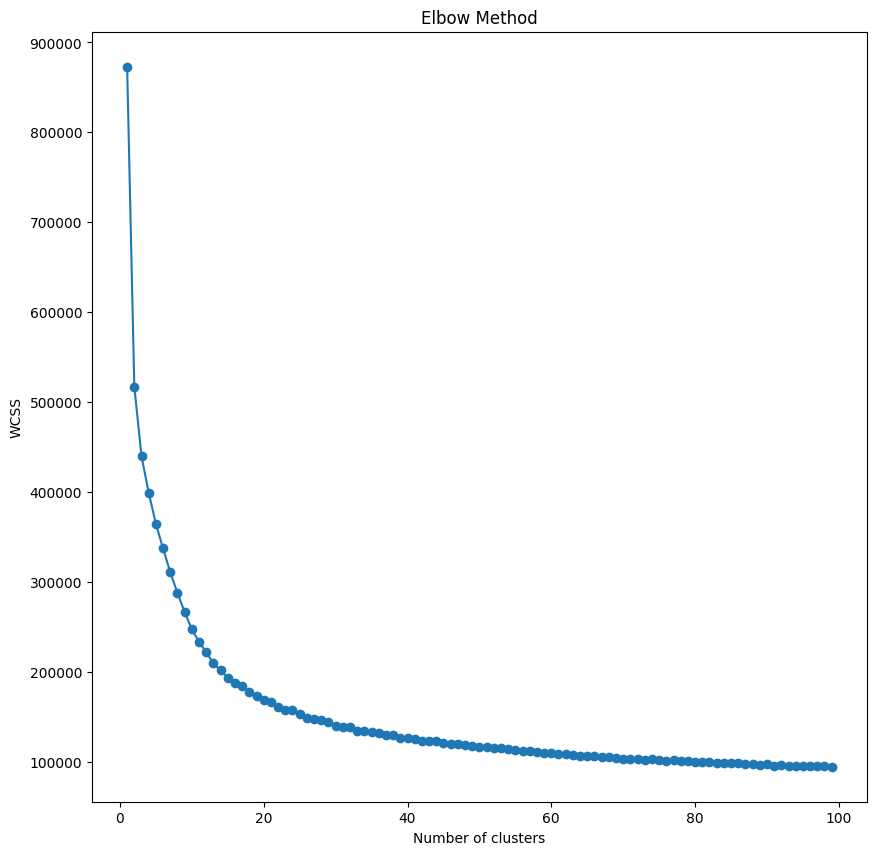

In [31]:
# Elbow method plotting
plt.figure(figsize=(10,10))
plt.plot(range(1, 100), wcss, marker = 'o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [35]:

kmeans = KMeans(n_clusters=25, init='k-means++', max_iter=100, n_init=10, random_state=1, )
kmeans.fit(scaled_data)
labels = kmeans.labels_

silhouette_avg = silhouette_score(scaled_data, labels)
davies_bouldin_avg = davies_bouldin_score(scaled_data, labels)
calinski_harabasz_avg = calinski_harabasz_score(scaled_data, labels)

print(f'Silhouette Score: {silhouette_avg}')
print(f'Davies-Bouldin Score: {davies_bouldin_avg}')
print(f'Calinski-Harabasz Score: {calinski_harabasz_avg}')

Silhouette Score: 0.2175295584627263
Davies-Bouldin Score: 1.4596126673579655
Calinski-Harabasz Score: 757.7191766411868


In [ ]:
# Create a pairplot with the specified colors
# sns.pairplot(component_wise_df, hue='Cluster', palette='tab10')
# plt.show()

### Agglomerative Clustering

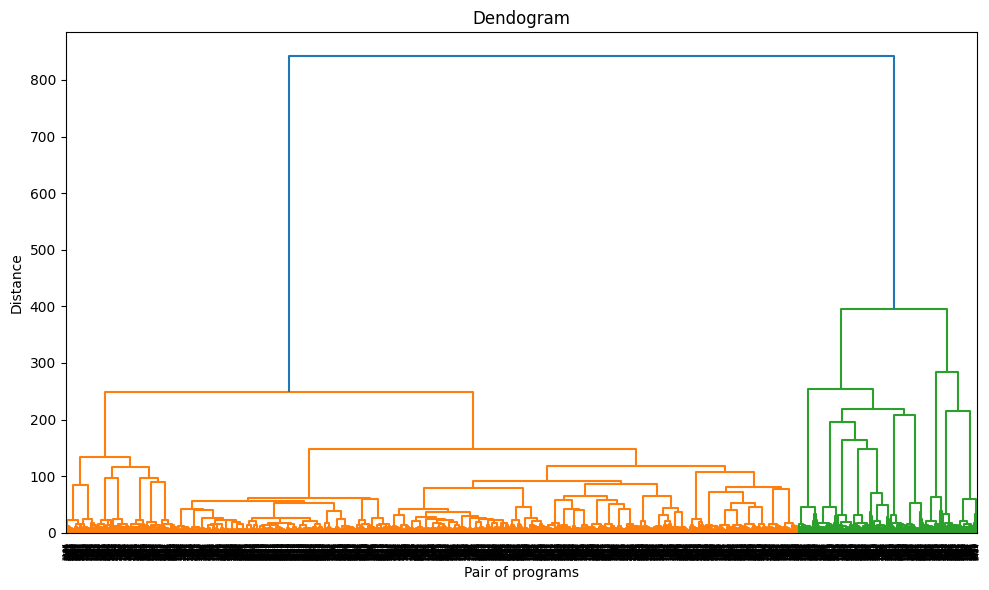

In [36]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(scaled_data, method='ward', metric='euclidean')

plt.figure(figsize=(10, 6))
dendrogram(Z, labels=data.index.values, orientation='top')
plt.title("Dendogram")
plt.xlabel("Pair of programs")
plt.ylabel("Distance")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [50]:
from sklearn.cluster import AgglomerativeClustering

cluster_ward_1 = AgglomerativeClustering(n_clusters=60, linkage='ward')# For data of differences
cluster_ward_2 = AgglomerativeClustering(n_clusters=40, linkage='ward')

# cluster_ward_1 = AgglomerativeClustering(n_clusters=50, linkage='ward')
# cluster_ward_2 = AgglomerativeClustering(n_clusters=60, linkage='ward')

y_ward_1 = cluster_ward_1.fit_predict(scaled_data)
y_ward_2 = cluster_ward_2.fit_predict(scaled_data)

data['agglomerative_ward_2'] = y_ward_2
data['agglomerative_ward_1'] = y_ward_1

In [ ]:
# Create a pairplot with the specified colors
# sns.pairplot(data, hue='agglomerative_ward_2', palette='viridis')
# plt.show()

In [51]:
silhouette_avg_agg_1 = silhouette_score(scaled_data, y_ward_1)
silhouette_avg_agg_2 = silhouette_score(scaled_data, y_ward_2)

davies_bouldin_avg_agg_1 = davies_bouldin_score(scaled_data, y_ward_1)
davies_bouldin_avg_agg_2 = davies_bouldin_score(scaled_data, y_ward_2)

calinski_harabasz_avg_agg_1 = calinski_harabasz_score(scaled_data, y_ward_1)
calinski_harabasz_avg_agg_2 = calinski_harabasz_score(scaled_data, y_ward_2)

# Look for values closer to one
print(f'Silhouette Score for x clusters: {silhouette_avg_agg_1}')
print(f'Silhouette Score for y clusters: {silhouette_avg_agg_2}')

# Look for bigger values
print(f'Calinski Harabaz Score for x clusters: {calinski_harabasz_avg_agg_1}')
print(f'Calinski Harabaz Score for y clusters: {calinski_harabasz_avg_agg_2}')

# Look for smaller values
print(f'Davies Bouldin Score for x clusters: {davies_bouldin_avg_agg_1}')
print(f'Davies Bouldin Score for y clusters: {davies_bouldin_avg_agg_2}')

Silhouette Score for x clusters: 0.25737985047365886
Silhouette Score for y clusters: 0.2409343923220998
Calinski Harabaz Score for x clusters: 456.95488598710676
Calinski Harabaz Score for y clusters: 583.6523349877413
Davies Bouldin Score for x clusters: 1.5966662725323124
Davies Bouldin Score for y clusters: 1.5909758625188648


## DBSCAN

[0 0 0 ... 0 0 0]
Número estimado de clusters: 2


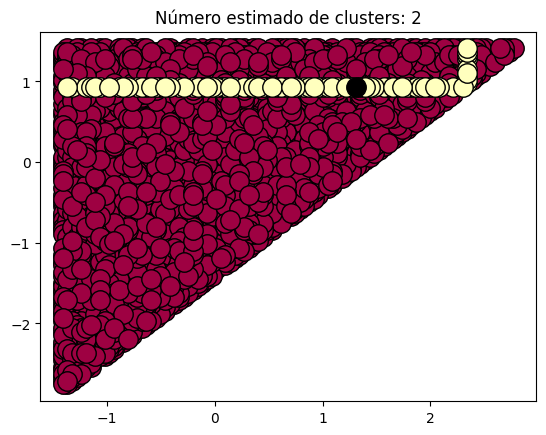

Silhouette Score: 0.5548886622990529
Davies-Bouldin Score: 0.4350397003489492
Calinski-Harabasz Score: 342.61556909558016


In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Seleccionar columnas numéricas
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Normalizar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Aplicar DBSCAN
db = DBSCAN(eps=25, min_samples=2).fit(scaled_data)
labels = db.labels_
print(labels)

# Número de clusters en las etiquetas, ignorando el ruido si está presente.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print(f'Número estimado de clusters: {n_clusters_}')

silhouette_avg = silhouette_score(scaled_data, labels)
davies_bouldin_avg = davies_bouldin_score(scaled_data, labels)
calinski_harabasz_avg = calinski_harabasz_score(scaled_data, labels)

# Visualizar los resultados
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Negro se usa para ruido.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = scaled_data[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

plt.title(f'Número estimado de clusters: {n_clusters_}')
plt.show()

print(f'Silhouette Score: {silhouette_avg}')
print(f'Davies-Bouldin Score: {davies_bouldin_avg}')
print(f'Calinski-Harabasz Score: {calinski_harabasz_avg}')

## MeanShift

In [114]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.cluster import MeanShift, estimate_bandwidth
# from sklearn.preprocessing import StandardScaler

# # Seleccionar columnas numéricas
# numeric_data = data.select_dtypes(include=['float64', 'int64'])

# # Normalizar los datos
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(numeric_data)

# # Estimar el ancho de banda para MeanShift
# bandwidth = estimate_bandwidth(scaled_data, quantile=0.5, n_samples=10)

# # Aplicar MeanShift
# ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
# ms.fit(scaled_data)
# labels = ms.labels_
# cluster_centers = ms.cluster_centers_

# # Número de clusters
# n_clusters_ = len(np.unique(labels))

# print(f'Número estimado de clusters: {n_clusters_}')

# # Calcular métricas
# silhouette_avg = silhouette_score(scaled_data, labels)
# davies_bouldin_avg = davies_bouldin_score(scaled_data, labels)
# calinski_harabasz_avg = calinski_harabasz_score(scaled_data, labels)

# # Visualizar los resultados
# unique_labels = np.unique(labels)
# colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
# for k, col in zip(unique_labels, colors):
#     class_member_mask = (labels == k)
#     xy = scaled_data[class_member_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=14)

# # Dibujar los centros de los clusters
# for k, col in zip(unique_labels, colors):
#     class_member_mask = (labels == k)
#     cluster_center = cluster_centers[k]
#     plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=22, alpha=0.5)

# plt.title(f'Número estimado de clusters: {n_clusters_}')
# plt.show()

# print(f'Silhouette Score: {silhouette_avg}')
# print(f'Davies-Bouldin Score: {davies_bouldin_avg}')
# print(f'Calinski-Harabasz Score: {calinski_harabasz_avg}')


## Spectral Clustering

/home/chony/.local/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Silhouette Score: 0.15756153810827783
Davies-Bouldin Score: 1.9387608927067776
Calinski-Harabasz Score: 817.943044463857


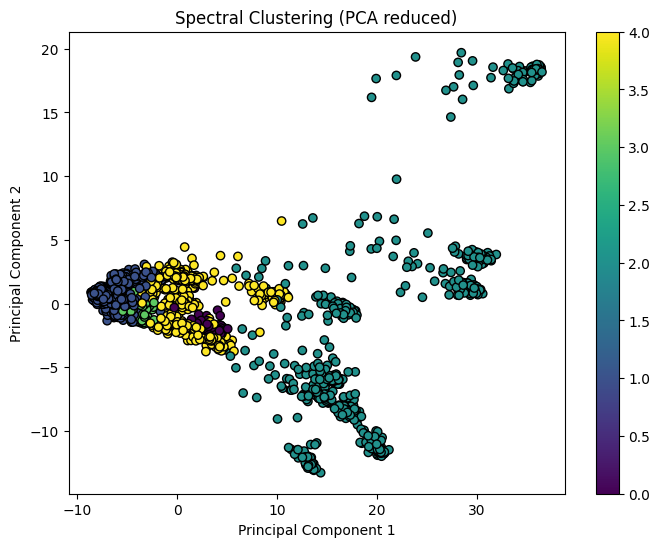

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

# Seleccionar columnas numéricas
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Normalizar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Aplicar Spectral Clustering
n_clusters = 5  # Número de clusters
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
labels = spectral.fit_predict(scaled_data)

# Calcular métricas de evaluación
silhouette_avg = silhouette_score(scaled_data, labels)
davies_bouldin_avg = davies_bouldin_score(scaled_data, labels)
calinski_harabasz_avg = calinski_harabasz_score(scaled_data, labels)

# Reducir la dimensionalidad para visualización con PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# Visualizar los resultados
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', edgecolors='k')
plt.title('Spectral Clustering (PCA reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()

print(f'Silhouette Score: {silhouette_avg}')
print(f'Davies-Bouldin Score: {davies_bouldin_avg}')
print(f'Calinski-Harabasz Score: {calinski_harabasz_avg}')
plt.show()

# Siamese NN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from SNN.siamese_network_parse import PrepareDataSNN

# Definir la arquitectura base
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Dense(128, activation='relu')(input)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

# Definir la función de distancia
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

# Crear el modelo de red siamesa
def create_siamese_network(input_shape):
    base_network = create_base_network(input_shape)

    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    # Obtener las representaciones de las dos ramas
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    # Calcular la distancia entre las dos salidas
    distance = Lambda(euclidean_distance, output_shape=(1,))([processed_a, processed_b])

    model = Model([input_a, input_b], distance)
    return model

# Definir la función de pérdida
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

# Entrenar el modelo
def train_siamese_network(data_a, data_b, labels):
    input_shape = (data_a.shape[1],)
    model = create_siamese_network(input_shape)

    model.compile(loss=contrastive_loss, optimizer=Adam(learning_rate=0.001))

    model.fit([data_a, data_b], labels, batch_size=128, epochs=20)

# Ejecutar el entrenamiento
if __name__ == "__main__":
    data = PrepareDataSNN()
    data_a, data_b, labels = data.process()
    train_siamese_network(data_a, data_b, labels)


ModuleNotFoundError: No module named 'tensorflow'